In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import matplotlib.gridspec as gridspec
import ast
import sys
sys.path.append('machine-scientist/')
sys.path.append('machine-scientist/Prior/')
from mcmc import *
from parallel import *
from fit_prior import read_prior_par

from sklearn.metrics import mean_squared_error

In [3]:
#Read NN and BMS data
n=0;id=0;function='tanh' #tanh, leaky_ReLU
NPAR=10 #10, 20
noise=True

#Read NN data
train_size=60
if noise==True:
    file_model='NN_model_noise_' + function + '_train_' +str(train_size)+ '_NREP_10_data' + '.csv'
else:
    file_model='NN_model_' + function + '_train_' +str(train_size)+ '_NREP_10_data' + '.csv'
model_d='../data/' + file_model
d=pd.read_csv(model_d)
dn=d[d['rep']==n]
dn.set_index('Unnamed: 0', inplace=True)
dn.index.name = None
dn=dn.reset_index(drop=True)
#Read BMS data
if noise==True:
    filename='BMS_noise_' + function + '_trace.' + str(n) + '_prior_'  + str(NPAR) + '_id_' + str(id) + '.csv'
else:
    filename='BMS_' + function + '_trace.' + str(n) + '_prior_'  + str(NPAR) + '_id_' + str(id) + '.csv'
print(filename)
trace=pd.read_csv('../data/MSTraces/' + filename, sep=';', header=None, names=['t', 'H', 'expr', 'parvals', 'kk1', 'kk2','kk3'])
display(trace)

BMS_noise_tanh_trace.0_prior_10_id_0.csv


,t,H,expr,parvals,kk1,kk2,kk3
0,0,20.425480,_a0_,"{'d0': {'_a0_': 0.6052582287650271, '_a1_': 1....",{'d0': 6.054723202456025},40.850959,0.00000
1,1,20.425480,_a0_,"{'d0': {'_a0_': 0.6052582287650271, '_a1_': 1....",{'d0': 6.054723202456025},40.850959,0.00000
2,2,20.425480,_a0_,"{'d0': {'_a0_': 0.6052582287650271, '_a1_': 1....",{'d0': 6.054723202456025},40.850959,0.00000
3,3,20.425480,_a0_,"{'d0': {'_a0_': 0.6052582287650271, '_a1_': 1....",{'d0': 6.054723202456025},40.850959,0.00000
4,4,20.425480,_a0_,"{'d0': {'_a0_': 0.6052582287650271, '_a1_': 1....",{'d0': 6.054723202456025},40.850959,0.00000
...,...,...,...,...,...,...,...
49995,49995,-14.942945,((sin(cos((-(((x1 * x1) * (_a2_ + (_a1_ + _a5_...,"{'d0': {'_a1_': -3.5397061921273623, '_a2_': 0...",{'d0': 0.1526531281140942},-167.691551,68.90283
49996,49996,-14.942945,((sin(cos((-(((x1 * x1) * (_a2_ + (_a1_ + _a5_...,"{'d0': {'_a1_': -3.5397061921273623, '_a2_': 0...",{'d0': 0.1526531281140942},-167.691551,68.90283
49997,49997,-14.942945,((sin(cos((-(((x1 * x1) * (_a2_ + (_a1_ + _a5_...,"{'d0': {'_a1_': -3.5397061921273623, '_a2_': 0...",{'d0': 0.1526531281140942},-167.691551,68.90283
49998,49998,-14.942945,((sin(cos((-(((x1 * x1) * (_a2_ + (_a1_ + _a5_...,"{'d0': {'_a1_': -3.5397061921273623, '_a2_': 0...",{'d0': 0.1526531281140942},-167.691551,68.90283


In [4]:
#Parameters to read models
VARS = ['x1',]
x = dn[[c for c in VARS]].copy()
if noise==True:
    y=dn.y_noise
else:
    y = dn.y

if NPAR==10:
    prior_par = read_prior_par('machine-scientist/Prior/final_prior_param_sq.named_equations.nv1.np10.2017-10-18 18:07:35.089658.dat')
elif NPAR==20:
    prior_par = read_prior_par('machine-scientist/Prior/final_prior_param_sq.named_equations.nv1.np20.maxs200.2024-05-10 162907.551306.dat')

In [5]:
#mdl model
minrow = trace[trace.H == min(trace.H)].iloc[0]
minH, minexpr, minparvals = minrow.H, minrow.expr, ast.literal_eval(minrow.parvals)

t = Tree(
    variables=list(x.columns),
    parameters=['a%d' % i for i in range(NPAR)],
    x=x, y=y,
    prior_par=prior_par,
    max_size=200,
    from_string=minexpr,
)

t.set_par_values(deepcopy(minparvals))

In [6]:
#Sample trace
sample_step=100
trace_s=trace.iloc[::sample_step, :]
models=len(trace_s.index)
print(models)

500


In [7]:
dall = deepcopy(dn)

dsample= pd.DataFrame({'ybms_' + str(row): [] for row in range(models)})
expressions=[]
for row in range(models):
    H_r, expr_r, parvals_r = trace_s.iloc[row].H, trace_s.iloc[row].expr, ast.literal_eval(trace_s.iloc[row].parvals)
    
    t = Tree(
    variables=list(x.columns),
    parameters=['a%d' % i for i in range(NPAR)],
    x=x, y=y,
    prior_par=prior_par,
    max_size=200,
    from_string=expr_r,
)
    t.set_par_values(deepcopy(parvals_r))

    dsample['ybms_' + str(row)] = t.predict(x)
    expressions.append(t.latex() )

#Remove columns with nans and infs
dsample.replace([np.inf, -np.inf], np.nan, inplace=True)
dsample=dsample.dropna(axis='columns')

#Calculate median of sampled models
dmedian=pd.DataFrame({'ybms_median': dsample[ [i for i in dsample.columns] ].median(axis=1)})
#Add median column to dataframe
dsample=pd.concat([dsample,dmedian], axis=1)

In [8]:
#Find the model with the minimum MSE
mse_models=[mean_squared_error(dsample[i], dsample.ybms_median) for i in dsample.columns[:-1]]

#The best model minimezes the error with the median prediction
best_model=mse_models.index(min(mse_models)) #find best model

print(min(mse_models))
print(best_model)

0.00013785903862365137
465


,x1,y,rep,noise,y_noise,ymodel,ybms_465,ybms_median,ybms_mdl
0,-1.95,0.052185,0.0,-0.098356,-0.046170,-0.033096,0.062404,0.029241,0.046633
1,-1.90,0.056609,0.0,0.063793,0.120402,0.089666,0.062405,0.034088,0.043185
2,-1.85,0.061686,0.0,0.037121,0.098807,0.124762,0.062415,0.040554,0.041616
3,-1.80,0.067569,0.0,0.056457,0.124026,0.109016,0.062471,0.037593,0.042579
4,-1.75,0.074452,0.0,-0.027125,0.047327,0.077262,0.062743,0.041989,0.046718
...,...,...,...,...,...,...,...,...,...
75,1.80,0.997513,0.0,-0.003770,0.993744,0.952475,0.063082,0.821292,1.375286
76,1.85,0.997161,0.0,-0.001211,0.995950,0.951946,0.062523,0.839160,1.311790
77,1.90,0.996811,0.0,0.046994,1.043805,0.951424,0.062420,0.869098,1.249706
78,1.95,0.996446,0.0,-0.007975,0.988471,0.950909,0.062406,0.899070,1.197896


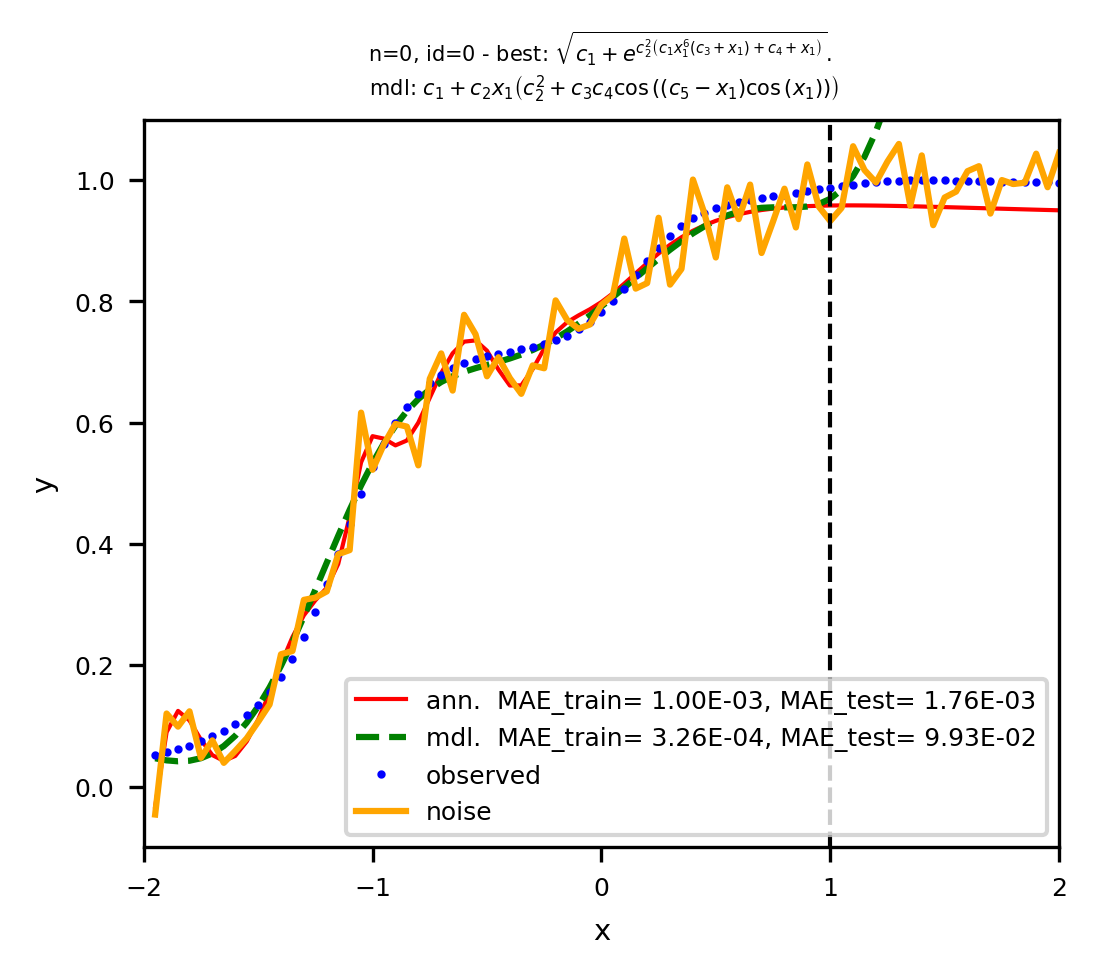

In [9]:
dn['ybms_'+ str(best_model)]=dsample['ybms_'+ str(best_model)]
dn['ybms_median']=dsample['ybms_median']
dn['ybms_mdl'] = t.predict(x)
display(dn)
#dsample.replace([np.inf, -np.inf], np.nan, inplace=True)
dn=dn.dropna(axis='columns')


MAE_bms=mean_squared_error(dn['ybms_' + str(best_model)],dn.y)

MAE_median=mean_squared_error(dn['ybms_median'],dn.y)
MAE_nn=mean_squared_error(dn.ymodel,dn.y)
MAE_nn_train=mean_squared_error(dn.loc[:train_size-1]['ymodel'],dn.loc[:train_size -1]['y'])
MAE_nn_test=mean_squared_error(dn.loc[train_size-1:]['ymodel'],dn.loc[train_size -1:]['y'])

try:
    MAE_mdl=mean_squared_error(dn.ybms_mdl,dn.y)
    MAE_mdl_train=mean_squared_error(dn.loc[:train_size-1]['ybms_mdl'],dn.loc[:train_size-1]['y'])
    MAE_mdl_test =mean_squared_error(dn.loc[train_size-1:]['ybms_mdl'],dn.loc[train_size-1:]['y'])
except AttributeError:
    print("mdl model contains nans")


#Plot
train_border=dn.loc[train_size-1]['x1']
#Define figure size in cm                                                                           
cm = 1/2.54 #convert inch to cm                                                                     
width = 10*cm; height=8*cm



#Fonts and sizes                                                                                    
size_axis=7;size_ticks=6;size_title=5
line_w=1;marker_s=3 #width and marker size                                                          

fig=figure(figsize=(width,height), dpi=300)


plt.title('n=%d, id=%d - best: $%s$. \n mdl: $%s$' % (n, id, expressions[best_model], t.latex()),fontsize=size_title)
plt.plot(dn['x1'], dn['ymodel'],linewidth=line_w, color='red', label='ann.  MAE_train= %.2E, MAE_test= %.2E' % \
         ( MAE_nn_train, MAE_nn_test)) 
try:
    plt.plot(dn['x1'], dn['ybms_mdl'],color='green', linestyle='--', label='mdl.  MAE_train= %.2E, MAE_test= %.2E' % \
             ( MAE_mdl_train, MAE_mdl_test))
except KeyError:
    print("mdl model contains nans")
plt.plot(dn['x1'], dn['y'],'.', markersize=2, color='blue',label='observed')  
plt.plot(dn['x1'], dn['y_noise'], color='orange', label='noise')

plt.axvline(x=train_border,linestyle='--',linewidth=line_w, color='k')


plt.xlabel('x',fontsize=size_axis);plt.ylabel('y',fontsize=size_axis)
plt.xticks(fontsize=size_ticks);plt.yticks(fontsize=size_ticks)
plt.legend(loc='best', fontsize=size_ticks)

plt.xlim(-2,2);plt.ylim(-0.1,1.1)                                               

if noise==True:
    Name_figure='mdl_noise_' + function + '_' + str(n) + '_' + str(id)
else:
    Name_figure='best_median_mdl_' + function + '_' + str(n) + '_' + str(id)

Extensions=['.png']
for ext in Extensions:
        plt.savefig('../results/' + Name_figure +ext,dpi=300)

plt.show()

1.913874515756653e-06


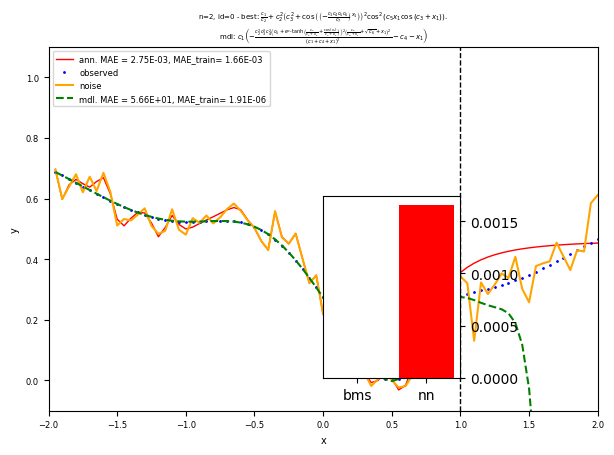

In [105]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

cm = 1/2.54 #convert inch to cm                                                                     
width = 18*cm; height=10*cm

fig = plt.figure(figsize=[width, height])
ax = fig.add_subplot(111)

Extensions=['.png']

#Fonts and sizes                                                                                    
size_axis=7;size_ticks=6;size_title=5
line_w=1;marker_s=3 #width and marker size                                                          

#fig=figure(figsize=(width,height), dpi=300)


plt.title('n=%d, id=%d - best: $%s$. \n mdl: $%s$' % (n, id, expressions[best_model], t.latex()),fontsize=size_title)
plt.plot(dn['x1'], dn['ymodel'],linewidth=line_w, color='red', label='ann. MAE = %.2E, MAE_train= %.2E' % (MAE_nn, MAE_nn_train)) 
plt.plot(dn['x1'], dn['y'],'.', markersize=2, color='blue',label='observed')  
plt.plot(dn['x1'], dn['y_noise'], color='orange', label='noise')
try:
    plt.plot(dn['x1'], dn['ybms_mdl'],color='green', linestyle='--', label='mdl. MAE = %.2E, MAE_train= %.2E' % (MAE_mdl, MAE_mdl_train))
except KeyError:
    print("mdl model contains nans")


plt.axvline(x=train_border,linestyle='--',linewidth=line_w, color='k')


plt.xlabel('x',fontsize=size_axis);plt.ylabel('y',fontsize=size_axis)
plt.xticks(fontsize=size_ticks);plt.yticks(fontsize=size_ticks)
plt.legend(loc='best', fontsize=size_ticks)

plt.xlim(-2,2);plt.ylim(-0.1,1.1)                                               

# Create an inset outside the Axes
axins = inset_axes(ax, width="100%", height="100%",
                   bbox_to_anchor=(0.5, .09, .25, .5),
                   bbox_transform=ax.transAxes, loc=2, borderpad=0)

axins.tick_params(left=False, right=True, labelleft=False, labelright=True)
x_MAE=['bms', 'nn']
print(MAE_mdl_train)
y_MAE=[ MAE_mdl_train, MAE_nn_train]
axins.bar(x_MAE, y_MAE, label=x_MAE, color=['green', 'red' ])
#axins.set_yticks([0, max(MAE_mdl_train, MAE_nn_train)])


Name_figure='best_median_mdl_' + function + '_' + str(n) + '_' + str(id)
for ext in Extensions:
        plt.savefig('../results/' + Name_figure +ext,dpi=300)

plt.show()

In [ ]:
fig=figure(figsize=(width,height), dpi=300)

plt.plot([0,1], [0,1],linestyle='--',linewidth=line_w)
plt.scatter(dn.loc[:train_size-1]['y'],dn.loc[:train_size-1]['ybms_'+ str(best_model)] , s=marker_s-1, color='red',label='train')
plt.scatter(dn.loc[train_size:]['y'],dn.loc[train_size:]['ybms_'+ str(best_model)] , s=marker_s-1, color='orange',label='test')

plt.show()